In [58]:
# adapted version of https://www.kaggle.com/cbrogan/titanic/xgboost-example-python/code
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
%matplotlib inline

# Load the data
train_df = pd.read_csv('../data/train.csv', header=0)
test_df = pd.read_csv('../data/test.csv', header=0)

col_labels = train_df.OutcomeType.unique()


# We'll impute missing values using the median for numeric columns and the most
# common value for string columns.
# This is based on some nice code by 'sveitser' at http://stackoverflow.com/a/25562948
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

feature_columns_to_use = ['AnimalType', 'SexuponOutcome']
nonnumeric_columns = ['AnimalType', 'SexuponOutcome']

# Join the features from train and test together before imputing missing values,
# in case their distribution is slightly different
# Do we really wanna do this? S/b said this is bad practice for some reason
big_X = train_df[feature_columns_to_use].append(test_df[feature_columns_to_use])
big_X_imputed = DataFrameImputer().fit_transform(big_X)

# XGBoost doesn't (yet) handle categorical features automatically, so we need to change
# them to columns of integer values.
# See http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing for more
# details and options
le = LabelEncoder()
for feature in nonnumeric_columns:
    big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])

# Prepare the inputs for the model
train_X = big_X_imputed[0:train_df.shape[0]].as_matrix()
test_X = big_X_imputed[train_df.shape[0]::].as_matrix()
train_df.OutcomeType = le.fit_transform(train_df.OutcomeType)
train_y = train_df['OutcomeType']

## Parameters
Some information about parameter tweaking: [click](http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

### Objective
Set against which loss function the algorithm should minimize. What we need: Multiclass with probabilities. So we choose `multi:softprob`. This in return needs a parameter `num_class` which indicates the number of differenct classes. In our case thats the number of distinct values for cloumn `OutcomeType`

In [59]:
# right know these values fall from the sky. No idea what they mean. Needs investigation
param = {
    'objective': 'multi:softprob',
    'num_class': train_df.OutcomeType.nunique(),  # should be 5
#     'eta': 0.05,
#     'max_depth': 8,
#     'min_child_weight': 8,
#     'eval_metric' : 'auc',
#     'silent': 1,
#     'seed':1,
#     'subsample': 0.5,
#     'colsample_bytree' : 0.5,
#     'alpha' : 4
}

## Do the actual learning

In [60]:
num_round=100
from sklearn.cross_validation import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.01, random_state=10)

`train_test_split` is a shorthand to randomly split a training set into train/test data for cross validation. 

* `test_size`: sets the percentage of data used for the test set.
* `random_state`: is used to get reproducible randomness

In [61]:
xgmat = xgb.DMatrix(X_train, label=y_train)  # cross validation training set
xgmat_valid = xgb.DMatrix(X_valid, label=y_valid)  # cross validation test set
xgmat_test = xgb.DMatrix(test_X)  # the original test set from kaggle

transforms our generated cross validation data to a format readable by `xgboost`

In [62]:
watchlist = [(xgmat_valid, 'eval'),(xgmat, 'train')]

gbm = xgb.train(param, xgmat, num_round, watchlist, early_stopping_rounds=0)

[0]	eval-merror:0,425373	train-merror:0,391822
[1]	eval-merror:0,425373	train-merror:0,391822
[2]	eval-merror:0,425373	train-merror:0,391822
[3]	eval-merror:0,425373	train-merror:0,391822
[4]	eval-merror:0,425373	train-merror:0,391822
[5]	eval-merror:0,425373	train-merror:0,391822
[6]	eval-merror:0,425373	train-merror:0,391822
[7]	eval-merror:0,425373	train-merror:0,391822
[8]	eval-merror:0,425373	train-merror:0,391822
[9]	eval-merror:0,425373	train-merror:0,391822
[10]	eval-merror:0,425373	train-merror:0,391822
[11]	eval-merror:0,425373	train-merror:0,391822
[12]	eval-merror:0,425373	train-merror:0,391822
[13]	eval-merror:0,425373	train-merror:0,391822
[14]	eval-merror:0,425373	train-merror:0,391822
[15]	eval-merror:0,425373	train-merror:0,391822
[16]	eval-merror:0,425373	train-merror:0,391822
[17]	eval-merror:0,425373	train-merror:0,391822
[18]	eval-merror:0,425373	train-merror:0,391822
[19]	eval-merror:0,425373	train-merror:0,391822
[20]	eval-merror:0,425373	train-merror:0,391822
[2

We don't just simply learn a model but we observe how the precision evolves [more info](http://xgboost.readthedocs.io/en/latest/python/python_intro.html#training)
* `early_stopping_rounds`: will stop training if the precision did not improve in the set number of rounds
* `watchlist`: contains the parameters to watch while learning

__*train() only returns the last model, not necessarily the best one!*__  see [here](http://xgboost.readthedocs.io/en/latest/python/python_intro.html#prediction)

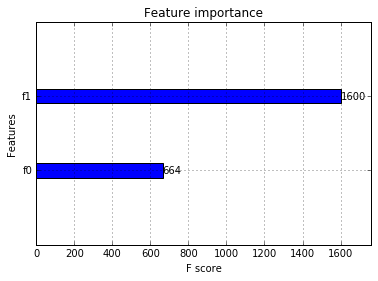

In [63]:
xgb.plot_importance(gbm)

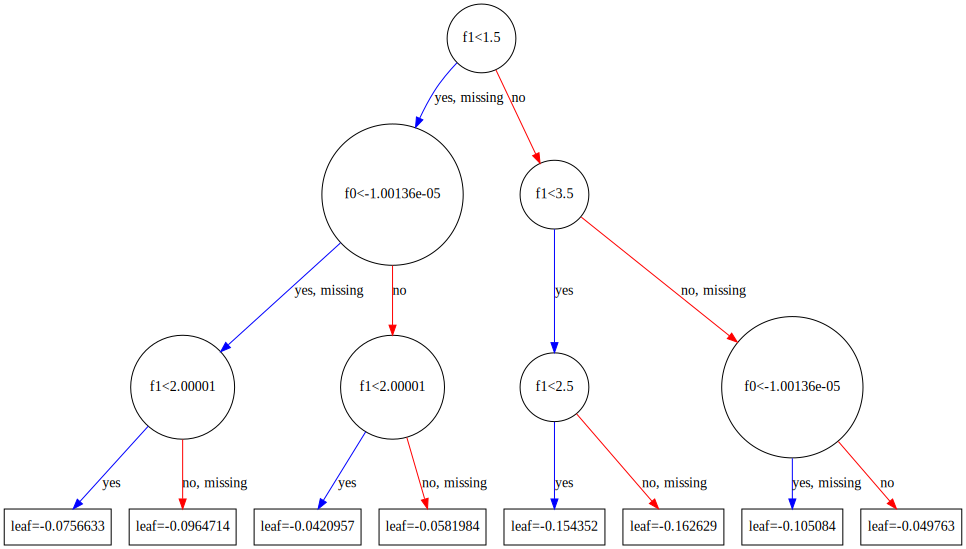

In [64]:
xgb.to_graphviz(gbm, num_trees=2)  # needs graphviz: 'sudo apt-get install graphviz' and 'pip3 install graphviz'

## Predict and save as Kaggel

In [65]:
predictions = gbm.predict(xgmat_test)

predictions

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  preds = preds.reshape(nrow, preds.size / nrow)


array([[ 0.04349564,  0.01159232,  0.13774991,  0.20307361,  0.60408849],
       [ 0.54317087,  0.00122114,  0.02715367,  0.26365417,  0.16480018],
       [ 0.65207964,  0.00296791,  0.03558032,  0.08269881,  0.22667336],
       ..., 
       [ 0.06724813,  0.01911447,  0.09698601,  0.00860181,  0.80804956],
       [ 0.4804523 ,  0.00150354,  0.03517972,  0.29615515,  0.18670927],
       [ 0.03782395,  0.00945825,  0.15500048,  0.29110247,  0.50661486]], dtype=float32)

In [66]:
# to kaggle format
submission_df = pd.DataFrame(predictions)
submission_df = pd.concat([test_df.ID, submission_df], axis=1)
submission_df.ID = submission_df.ID.astype(int)
submission_df.set_index('ID', inplace=True)
submission_df.columns = le.inverse_transform(sorted(train_df.OutcomeType.unique()))  # get the string labels back
submission_df.head()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
ID,,,,,
1,0.043496,0.011592,0.137750,0.203074,0.604088
2,0.543171,0.001221,0.027154,0.263654,0.164800
3,0.652080,0.002968,0.035580,0.082699,0.226673
4,0.037824,0.009458,0.155000,0.291102,0.506615
5,0.480452,0.001504,0.035180,0.296155,0.186709


In [67]:
submission_df.to_csv('submission.csv')
len(submission_df)

11456